In [1]:
import pandas as pd
import os
import shutil
import glob
import numpy as np

# Essential Libraries
import cv2
import pandas as pd
import matplotlib.pyplot as plt

#import av   # !pip install av
import numpy as np
import os
import torch
from transformers import VivitConfig, VivitModel, VivitImageProcessor
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, ToPILImage
from PIL import Image
from totem_utils import get_bbox

import matplotlib.colors as mcolors

# Display plots inline
%matplotlib inline

# Set plot parameters
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

In [2]:
# import av   # !pip install av
# import os

# fpath = "/Users/mikehemberger/Documents/vscode/totems/data/data-prototype/dataset_v1/"
# fname = "MVI_7423_pulse_wabbern-cropped"
# vid_filename = fname + ".mp4"
# os.makedirs(fpath + fname + '/images-from-av', exist_ok=True)
# container = av.open(os.path.join(fpath + fname, vid_filename))

# for frame in container.decode(video=0):
#    frame.to_image().save(fpath + fname + '/images-from-av/frame_%04d.jpg' % frame.index)

In [3]:
# Transfers data from roboflow download folder to data/data-prototype
copy_files = False

source_dir = '/Users/mikehemberger/Documents/vscode/totems/data/roboflow-dataset-download/totem-prototype.v1i.yolov7pytorch/'
target_dir = "./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/"
os.makedirs(os.path.join(target_dir, "images/renamed/"), exist_ok=True)
z_fill_ = 4

if copy_files:
    os.makedirs(target_dir, exist_ok=True)
    prefix = "MVI_7423_pulse_wabbern-cropped_mp4-"
    # Find all jpg and txt files in the source directory and its subdirectories
    for filename in glob.glob(source_dir + '/**/*.jpg', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".jpg"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)

    for filename in glob.glob(source_dir + '/**/*.txt', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".txt"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)


In [4]:
target_dir = "./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/"
filenames = sorted([f for f in os.listdir(target_dir) if f.endswith(".jpg")])
target_fpaths = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith(".jpg")]

df = pd.DataFrame(columns=["filename", "frame_idx", "frame_sec", "filepath", "cutout_fpath", "frame_str", "frame_int"])
sr = 40  # sampling rate
df["filename"] = filenames
df["frame_idx"] = [int(n) for n in range(len(df))]
df["frame_sec"] = df["frame_idx"] * sr  # 25hz, 40ms sr
df["filepath"] = target_fpaths
df["frame_int"] = [int(fn.split("frame_")[-1].split(".jpg")[0]) for fn in df["filename"].tolist()] #  .astype("int64")

# Save the dataframe
df.to_csv(os.path.join(target_dir, "prototype-v1-mvi-7423.csv"), index=False)
len(df)

805

In [5]:
# Load the dataframe
df = pd.read_csv(os.path.join(target_dir, "prototype-v1-mvi-7423.csv"))
T_idx = df["frame_idx"].max()

df = df.sort_values(by="frame_idx")

df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))
df["ori_filepath"] = sorted(df["filepath"].str.replace("images/renamed","images-from-av"))
df = df.iloc[:-1]

print(len(df))
print(df["filepath_txt"].tolist()[:5])
print(df["ori_filepath"].tolist()[:5])
df.head()

804
['./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0000.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0001.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0002.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0003.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0004.txt']
['./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0000.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0001.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0002.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0003.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0004.jpg']


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_35148/3680822996.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))


,filename,frame_idx,frame_sec,filepath,cutout_fpath,frame_str,frame_int,filepath_txt,ori_filepath
0,frame_0000.jpg,0,0,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,0,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
1,frame_0001.jpg,1,40,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,1,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
2,frame_0002.jpg,2,80,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,2,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
3,frame_0003.jpg,3,120,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,3,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
4,frame_0004.jpg,4,160,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,4,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...


In [6]:
from PIL import Image
import cv2

# resize
src = os.path.join("./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped", "images/renamed/")
src_ = os.path.join("./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped", "images-224/")
os.makedirs(src_, exist_ok=True)

filenames = sorted([f for f in os.listdir(src) if f.endswith(".jpg")])
resize = (224, 224)

# for fn in filenames:
#     img = Image.open(src+fn).resize(resize)
#     img.save(src_+fn)

In [7]:
annots = df["filepath_txt"].tolist()
filenames = df["filename"].tolist()
img_filepaths = df["ori_filepath"].tolist()

d = dict()

for idx, annot in enumerate(annots):
    im = Image.open(img_filepaths[idx])
    im_width, im_height = im.size

    with open(annot, 'r') as f:
        lines = f.read().splitlines()

        for nth, line in enumerate(lines):
            values = list(map(float, line.strip().split()))

            while values:
                class_id = int(values.pop(0))
                x_values = []
                y_values = []
                while values and len(values) >= 2:
                    x_values.append(values.pop(0))
                    y_values.append(values.pop(0))
                    x1 = int(min(x_values) * im_width)
                    y1 = int(min(y_values) * im_height)
                    x2 = int(max(x_values) * im_width)
                    y2 = int(max(y_values) * im_height)
                d.update({filenames[idx].split(".jpg")[0] + "_" + str(nth): np.array([[x1, x2],[y1, y2]])})

- spatial central point of bbox cluster sets to determine reliable LED position (can be ON and OFF)

In [8]:
#from totem_utils import get_bbox

search_list = list(d.keys()) 
means = list()

for nth in range(len(search_list)):
    search_for = f"frame_{str(nth).zfill(z_fill_)}_"#'frame_0000_'
    result_keys = [f for f in search_list if f.startswith(search_for)]

    bboxes = []
    for key in result_keys:
        means.append([np.mean(get_bbox(d, key)[:,0]), np.mean(get_bbox(d, key)[:,1])])


In [9]:
from sklearn.cluster import KMeans

cmap = plt.cm.jet
means_ = np.array(means)
colors = cmap(np.linspace(0, 1, len(means_)))[:,:3]

kmeans = KMeans(n_clusters=35, random_state=0)
kmeans.fit(means_)
assignments = kmeans.labels_
centers = kmeans.cluster_centers_
print("clusters", max(assignments))

clusters 34


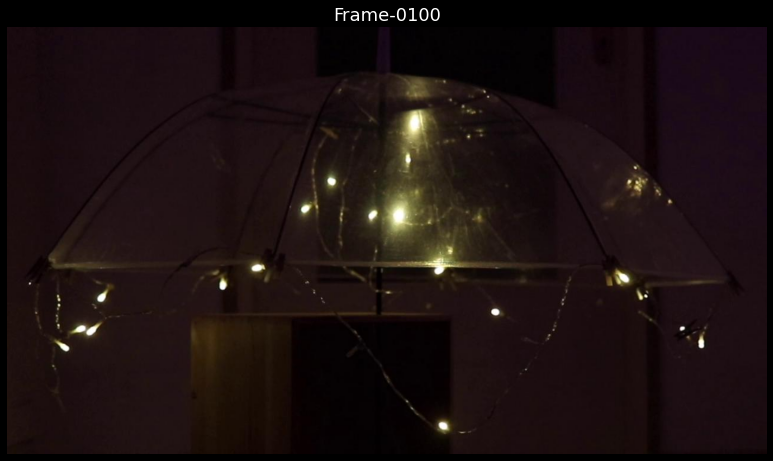

In [9]:
pixshiftx = 5
pixshifty = 5

plt.figure(figsize=(11,11))
plt.title("Frame-0100")
plt.imshow(Image.open(df.loc[100,"ori_filepath"]))
plt.axis("off")

# plt.scatter(means_[:,0], means_[:,1], color="c", alpha=.75, marker=".", edgecolors="none", s=15)
# plt.scatter(centers[:,0], centers[:,1], color="m", alpha=.8, marker="*", edgecolors="none", s=150)

# labels = list(map(str, range(1, len(centers) + 1)))
# for i in range(len(centers)):
#     plt.text(centers[i,0] + pixshiftx, centers[i,1] + pixshifty, labels[i], fontdict={"fontsize" : 17, "color" : "m"})

plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/Frame-0100-Illustration_.jpg", dpi=300)


# T-SNE of frames over time
- animate a short .gif version with low fr/sec
- overlap colors, sort by corr coeff (groups), mark valid bboxes with id string, color for clusters

In [10]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extraction = False

if feature_extraction:
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')  # 244-in21k
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', return_dict=True)  # 224-in21k

    filenames = df["filename"].tolist()
    feature_vectors = []
    for i, image in enumerate(filenames): 
        image = Image.open(src_+image)
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        feature_vector = outputs.pooler_output.detach().cpu().numpy()
        feature_vectors.append(feature_vector)

    feature_vectors = np.concatenate(feature_vectors, axis=0)
    print(feature_vectors.shape)

# Save and Load Feature Vectors

In [11]:
fv_name = "prototype-v1-mvi-7423-feature-vectors-224.npy"
#np.save(os.path.join(src_, fv_name), feature_vectors)
fvs = np.load(os.path.join(src_, fv_name))

In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=150, learning_rate=45, random_state=42, init="pca")
features_embedded = tsne.fit_transform(fvs)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


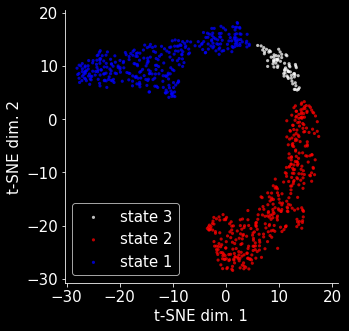

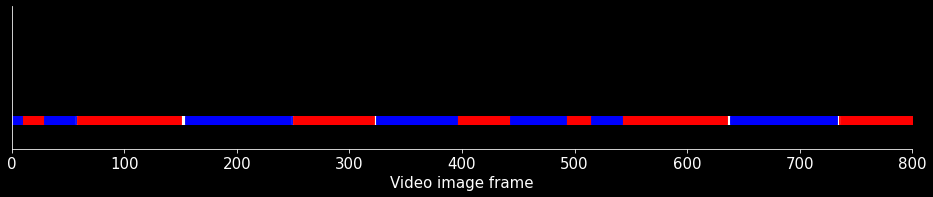

In [13]:
clusters = { #[[xmin, xmax],[ymin, ymax]]
    1 : [[5, 20], [5, 15]],
    3 : [[-10, 20], [-30, 4]],
    2 : [[-30, 4.9], [0, 20]],
}
cluster_names = ["state 1", "state 2", "state 3"]
cluster_names = sorted(cluster_names, reverse=True)

idxs = list()
for idx, xy in clusters.items():
    xidx = (features_embedded[:, 0] > xy[0][0]) & (features_embedded[:, 0] < xy[0][1])
    yidx = (features_embedded[:, 1] > xy[1][0]) & (features_embedded[:, 1] < xy[1][1])
    idxs.append(np.where((xidx & yidx))[0])

# idxs is "cluster_id"
ccolors = ["w", "r", "b"]
plt.figure(figsize=(5,5))
for nth, (cidx, c) in enumerate(zip(idxs, ccolors)):
    plt.scatter(features_embedded[cidx, 0], features_embedded[cidx, 1], color=c, alpha=.75, edgecolors="none", s=10, label=f"{cluster_names[nth]}")
plt.axis("square")
plt.xlabel("t-SNE dim. 1")
plt.ylabel("t-SNE dim. 2")
plt.tight_layout()
plt.legend()

plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-fv-tSNE_.jpg", dpi=300)

#

plt.figure(figsize=(13,3))
for cidx, c, cnames in zip(idxs, ccolors, cluster_names):
    plt.scatter(cidx, np.ones(len(cidx)), marker="s", color=c, s=50, alpha=.9, label=cnames)


plt.xlabel("Video image frame")
plt.yticks(ticks=[]);

plt.tight_layout()
plt.ylim([.975, 1.1])
plt.xlim([0, 800])
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-tSNE-states-over-time_.jpg", dpi=300)

- Clustered states over time

In [ ]:
# VIDEO for .gif making
filenames = df["filename"].tolist()
for nth, cid in enumerate(idxs):
    cfilenames = np.array(filenames)[cid]
    frame = cv2.imread(os.path.join(src_, cfilenames[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(src_ + f'videoX_{int(nth)+1}.avi', 0, 10, (width, height))
    
    for image in cfilenames:
        video.write(cv2.imread(os.path.join(src_, image)))
    cv2.destroyAllWindows()
    video.release()

    # create gifs later

# INNTEGRATE INTENSITY
- this step will take some time

In [14]:

xoffset = 10 * 1.5  # Enlarge bbox
yoffset = 10 * 1.5
bboxes_ = list()

for c__ in centers:
    x, y = c__
    x_min = max(0, x - xoffset)
    y_min = max(0, y - yoffset)
    x_max = x + xoffset
    y_max = y + yoffset
    bboxes_.append([int(y_min), int(y_max), int(x_min), int(x_max)])


xframes = [int(n) for n in range(len(df))]
mat = np.zeros((len(xframes), len(centers)))

for ith, bbox in enumerate(bboxes_):
    y_min, y_max, x_min, x_max = bbox

    for nth in xframes:
        intensity_matrix = np.array(Image.open(df.loc[nth, "ori_filepath"]))
        roi = intensity_matrix[int(y_min):int(y_max), int(x_min):int(x_max)]
        mat[nth, ith] = np.mean(roi) #/ (20*20)

np.max(mat)
#np.min(mat)

206.51074074074074

- start by plotting example frame series without annotations
- order into tSNE first

- then LED marks on img and Signals (sorted)

In [15]:
tindices

NameError: name 'tindices' is not defined

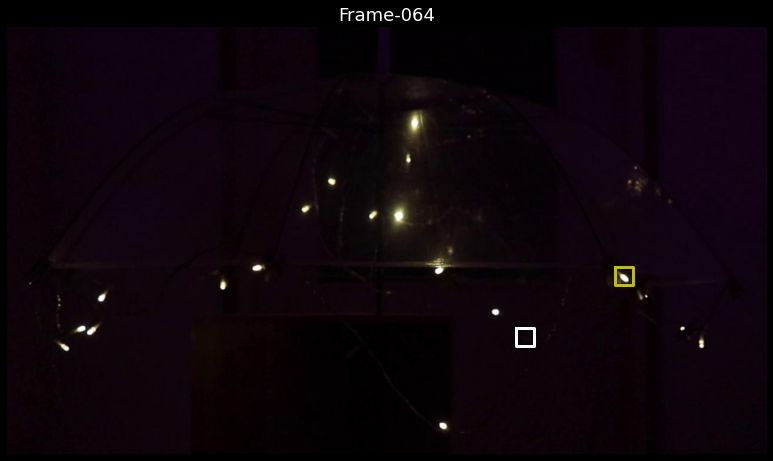

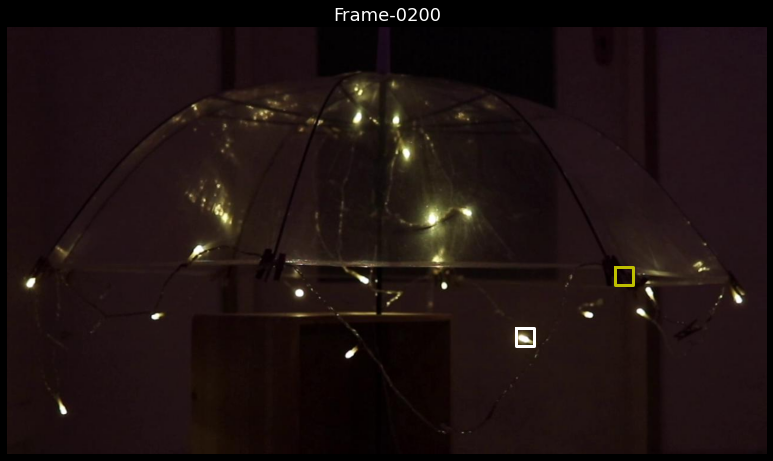

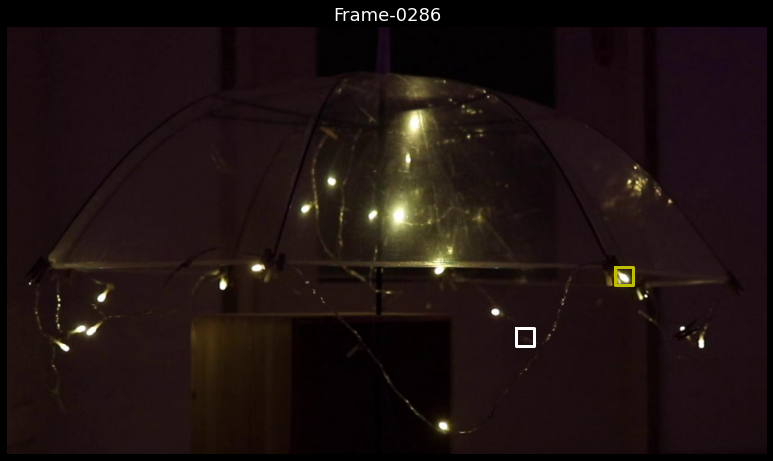

In [16]:
# PUT THE PLOTTING FUNCTION INTO TOTEM_UTILS
bboxes_ = list()
bboxes_all = list()

sample_LEDs = [21, 28]  #[5, 34]
centers_ = centers[sample_LEDs, :]
tvec = np.array([x  / 40 for x in xframes])

y = mat[:, sample_LEDs]
y_ = y  / max(y.max(axis=0))

for c__ in centers:
    x, y = c__
    x_min = max(0, x - xoffset)
    y_min = max(0, y - yoffset)
    x_max = x + xoffset
    y_max = y + yoffset
    bboxes_all.append([int(y_min), int(y_max), int(x_min), int(x_max)])

for c__ in centers_:
    x, y = c__
    x_min = max(0, x - xoffset)
    y_min = max(0, y - yoffset)
    x_max = x + xoffset
    y_max = y + yoffset
    bboxes_.append([int(y_min), int(y_max), int(x_min), int(x_max)])

FRAME = 64
img = np.array(Image.open(df.loc[FRAME,"ori_filepath"]))  #img = np.clip(img, 0, 105)  # '50' is the brightness factor
plt.figure(figsize=(11,11))
plt.title(f"Frame-0{FRAME}")
plt.imshow(img)
plt.axis("off")

# for bbox in bboxes_all:
#     plt.plot(
#         [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
#         [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
#         "-m", lw=1)

mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=3)

plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Frame-0000-Illustration_Frame-{FRAME}-BBoxes_TwoSelected-{[e for e in sample_LEDs]}_.jpg", dpi=300)

FRAME = 200
img = np.array(Image.open(df.loc[FRAME,"ori_filepath"]))  #img = np.clip(img, 0, 105)  # '50' is the brightness factor
plt.figure(figsize=(11,11))
plt.title(f"Frame-0{FRAME}")
plt.imshow(img)
plt.axis("off")

# for bbox in bboxes_all:
#     plt.plot(
#         [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
#         [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
#         "-m", lw=1)

mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=3)

plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Frame-0000-Illustration_Frame-{FRAME}-BBoxes_TwoSelected-{[e for e in sample_LEDs]}_.jpg", dpi=300)


FRAME = 286
img = np.array(Image.open(df.loc[FRAME,"ori_filepath"]))  #img = np.clip(img, 0, 105)  # '50' is the brightness factor
plt.figure(figsize=(11,11))
plt.title(f"Frame-0{FRAME}")
plt.imshow(img)
plt.axis("off")

# for bbox in bboxes_all:
#     plt.plot(
#         [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
#         [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
#         "-m", lw=1)

mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=3)

plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Frame-0000-Illustration_Frame-{FRAME}-BBoxes_TwoSelected-{[e for e in sample_LEDs]}_.jpg", dpi=300)

In [36]:
df.loc[63,:]

filename                                           frame_0064.jpg
frame_idx                                                      63
frame_sec                                                    2520
filepath        ./data/data-prototype/dataset_v1/MVI_7423_puls...
cutout_fpath                                                  NaN
frame_str                                                     NaN
frame_int                                                      64
filepath_txt    ./data/data-prototype/dataset_v1/MVI_7423_puls...
ori_filepath    ./data/data-prototype/dataset_v1/MVI_7423_puls...
Name: 63, dtype: object

[100 320 460]


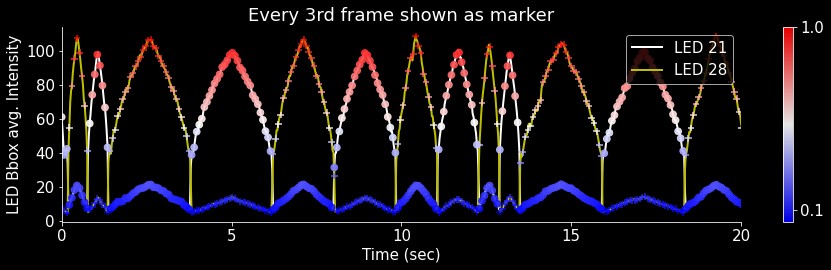

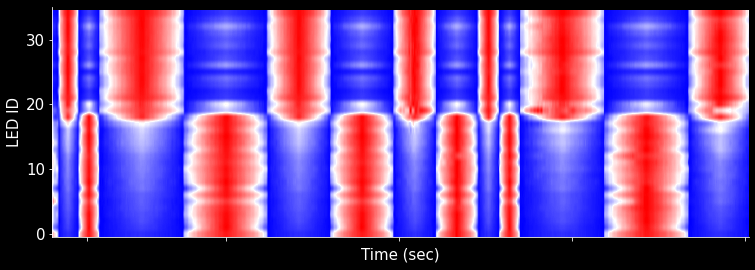

In [55]:
y = mat[:, sample_LEDs]  # y was overwritten in last step
y_ = y  / max(y.max(axis=0))

cmap = plt.cm.bwr
norm = mcolors.Normalize(vmin=y_.min(), vmax=y_.max())
markers = ['o', '+']  # List of marker styles

# PLOT 
plt.figure(figsize=(13,4))
plt.plot(tvec, y[:,0], "-",color="w", lw=2, alpha=1, zorder=1, label="LED " + str(sample_LEDs[0]))
plt.plot(tvec, y[:,1], "-", color="y", lw=2, alpha=1, zorder=1, label="LED " + str(sample_LEDs[1]))

show_every = 3
plt.title(f"Every {show_every}rd frame shown as marker")
for i in range(y.shape[1]):
    plt.scatter(tvec[::show_every], y[::show_every, i], c=y_[::show_every, i], cmap=cmap, norm=norm, marker=markers[i], s=45, alpha=.9, zorder=2)
plt.xticks(ticks=[0,5,10, 15,20])
plt.xlabel("Time (sec)")
plt.ylabel("LED Bbox avg. Intensity")
plt.xlim([0, 20])
plt.legend(title="", loc="upper right")
cbar = plt.colorbar(ticks=[0.1, 1], label="")
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-sample-raw-brightness_.jpg", dpi=300)

from scipy.signal import find_peaks

time_points = [2.5, 8, 11.5] #[2.5, 5, 17.25]#   # recent [1.7, 5, 7.15] original [2.5, 5, 17.25]
ccs = ["r", "b", "m"]

tindices = np.where(np.isin(tvec, time_points))[0]
print(tindices)
srt_idx = np.where([x == tindices[0] for x in xframes])[0]

norm_mat = (mat - mat.min(axis=0)) / (mat - mat.min(axis=0)).max(axis=0)
df_nmat = pd.DataFrame(norm_mat)

sorted_indices = np.argsort(df_nmat.iloc[srt_idx, :].values)[0]
df_sorted = df_nmat[sorted_indices].copy()
smat = df_sorted.to_numpy()

plt.figure(figsize=(10.75,4))
plt.imshow(np.transpose(smat), aspect="auto", cmap="bwr");

#for tp, c in zip(tindices, ccs):
#     plt.plot([xframes[tp], xframes[tp]], [0, 35], "--", color="w", lw=2);

plt.xticks(ticks=[x*40 for x in [1,5,10, 15,20]], labels=[])
#plt.xticks(ticks=[xframes[tp] for tp in tindices], labels=[tp for tp in time_points])
plt.ylabel("LED ID")
plt.xlabel("Time (sec)")
plt.ylim([-.5, 35])
plt.xlim([0, len(tvec)])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-thresholded-normalized-sorted_.jpg", dpi=300)


(19, 2) (16, 2)


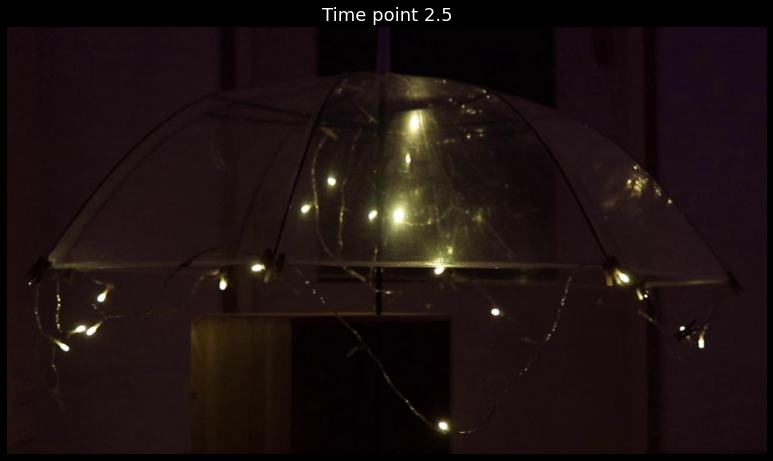

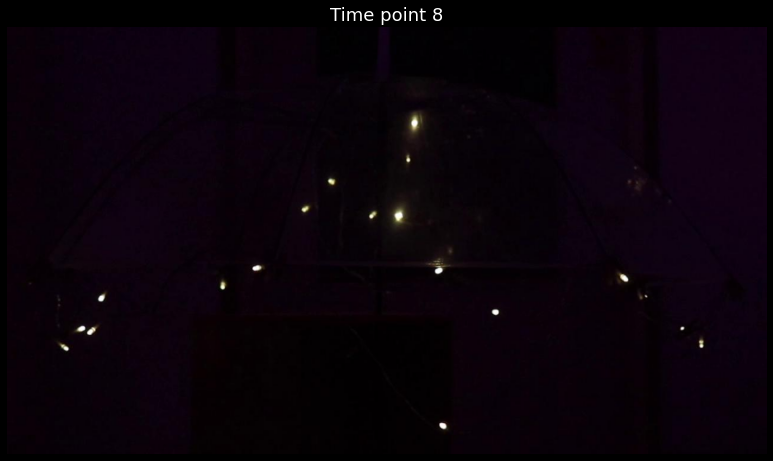

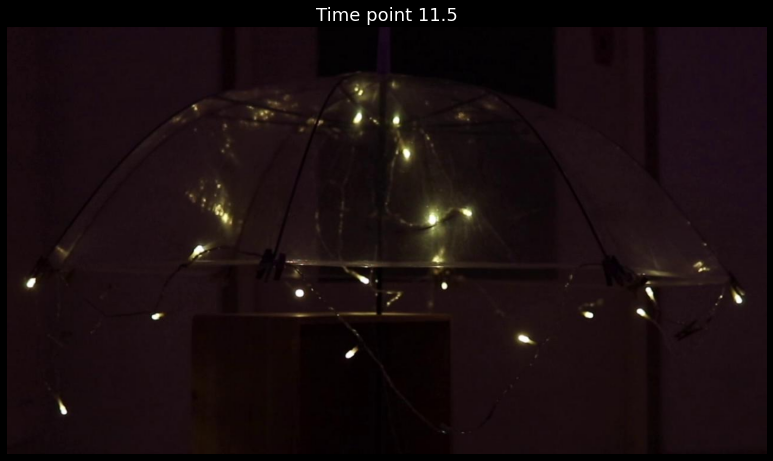

In [45]:
sorted_centers = centers[sorted_indices]
c1, c2 = sorted_centers[:19], sorted_centers[19:]
print(c1.shape, c2.shape)

xoffset = 15
yoffset = 15
sorted_centers = centers[sorted_indices]
color_idx = [["-b", "-r"],["-r", "-b"],["-b", "-r"]]

for tp, ti, ci in zip(time_points, tindices, color_idx):
    bboxes_1 = list()
    bboxes_2 = list()
    for c__ in c1:
        x, y = c__
        x_min = max(0, x - xoffset)
        y_min = max(0, y - yoffset)
        x_max = x + xoffset
        y_max = y + yoffset
        bboxes_1.append([int(y_min), int(y_max), int(x_min), int(x_max)])


    plt.figure(figsize=(11,11))
    plt.title(f"Time point {tp}")
    plt.imshow(Image.open(df.loc[int(xframes[ti]),"ori_filepath"]))
    plt.axis("off")

    # for bbox in bboxes_1:
    #     plt.plot(
    #         [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
    #         [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
    #         ci[0], lw=3, alpha=.75)

    for c__ in c2:
        x, y = c__
        x_min = max(0, x - xoffset)
        y_min = max(0, y - yoffset)
        x_max = x + xoffset
        y_max = y + yoffset
        bboxes_2.append([int(y_min), int(y_max), int(x_min), int(x_max)])


    # for bbox in bboxes_2:
    #     plt.plot(
    #         [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
    #         [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
    #         ci[1], lw=3, alpha=.75)
    
    plt.tight_layout()
    plt.savefig(f"./data/data-prototype/dataset_v1/Active-LEDs-timepoint_{tp}_tindex{ti}__wo.jpg", dpi=300)

# MAX INTensity proj of states to nail it! + blue and read for activity > compare overlay of projections (bboxes only)


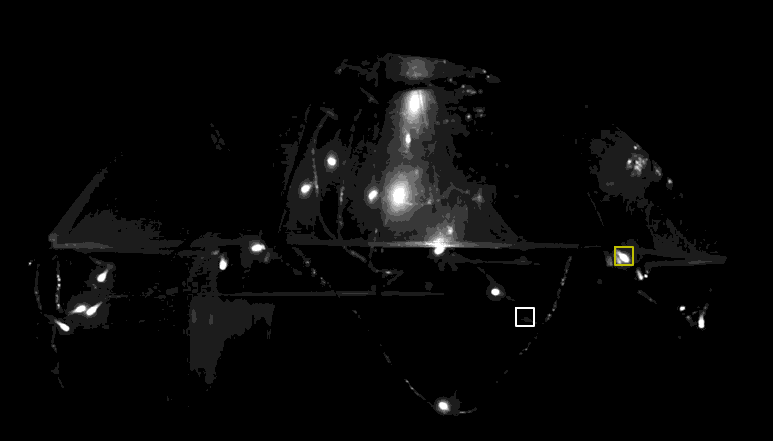

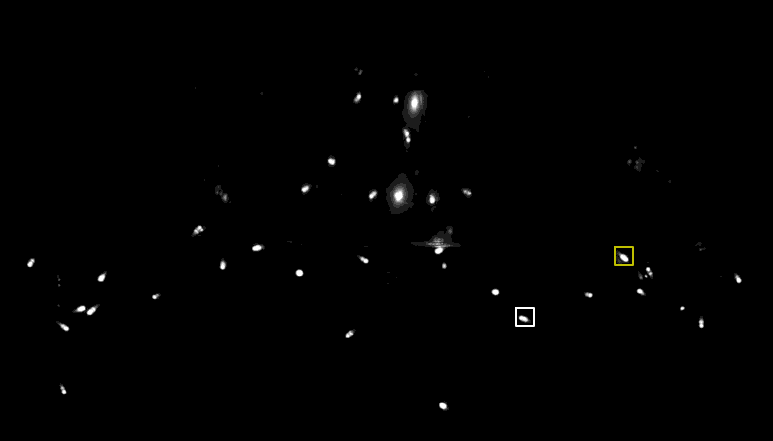

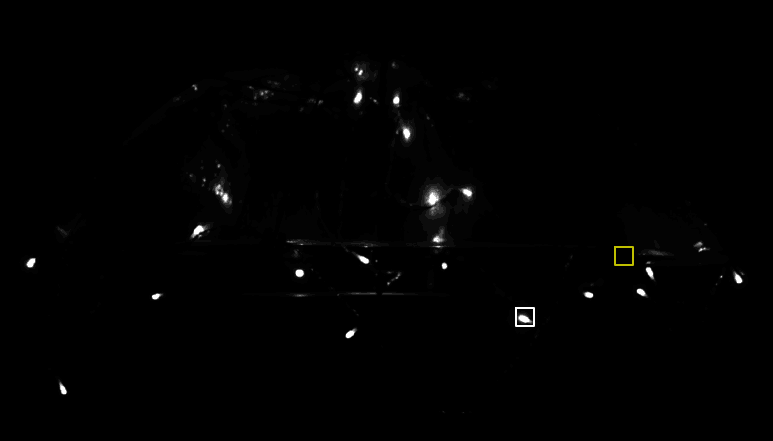

In [49]:
from matplotlib.colors import LinearSegmentedColormap

mip_A = None
mip_B = None
mip_C = None
Aidx = tindices[1]
Bidx = tindices[2]
Cidx = tindices[0]
cvec = [(1, 0, 0), (0, 1, 0)]
ncolors = 10

for cidx in [Cidx]:
    ti = [cidx-3, cidx+3]
    for i in range(ti[0], ti[1] + 1):
        img_array = np.array(Image.open(df.loc[int(xframes[i]),"ori_filepath"]).convert("L"))
        if mip_C is None:
            mip_C = img_array
        else:
            mip_C = np.maximum(mip_C, img_array)

colors = [(0, 0, 0), (1, 1, 1)]
bwcm = LinearSegmentedColormap.from_list("Custom", colors, N=ncolors)

plt.figure(figsize=(11,11))
plt.imshow(mip_C, cmap=bwcm, alpha=1)
plt.axis('off')
mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=2)
plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Max-Int-Projection-State-C-white.jpg", dpi=300)


for cidx in [Aidx]:
    ti = [cidx-3, cidx+3]
    for i in range(ti[0], ti[1] + 1):
        img_array = np.array(Image.open(df.loc[int(xframes[i]),"ori_filepath"]).convert("L"))
        if mip_A is None:
            mip_A = img_array
        else:
            mip_A = np.maximum(mip_A, img_array)

colors = [(0, 0, 0), (1, 1, 1)]
rcm = LinearSegmentedColormap.from_list("Custom", colors, N=ncolors)

plt.figure(figsize=(11,11))
plt.imshow(mip_A, cmap=rcm, alpha=1)
plt.axis('off')

mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=2)
plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Max-Int-Projection-State-A-red.jpg", dpi=300)

for cidx in [Bidx]:
    ti = [cidx-3, cidx+3]
    for i in range(ti[0], ti[1] + 1):
        img_array = np.array(Image.open(df.loc[int(xframes[i]),"ori_filepath"]).convert("L"))
        if mip_B is None:
            mip_B = img_array
        else:
            mip_B = np.maximum(mip_B, img_array)

colors = [(0, 0, 0, 0), (1, 1, 1, 1)]
bcm = LinearSegmentedColormap.from_list("Custom", colors, N=ncolors)

plt.figure(figsize=(11,11))
plt.imshow(mip_B, cmap=bcm)
plt.axis('off')
mcols = ["w", "y"]
for bbox, c in zip(bboxes_, mcols):
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-", color=c, lw=2)
plt.tight_layout()
plt.savefig(f"./data/data-prototype/dataset_v1/Max-Int-Projection-State-B-blue.png", dpi=300)


# make with annoth bbox

In [ ]:
# from scipy.signal import find_peaks

# sig = norm_mat#[:, sample_LEDs[0]]
# led_peaks = []
# for nth in range(sig.shape[1]):    
#     peaks, _ = find_peaks(sig[:, nth], height=led_thres)
#     if len(peaks[(peaks > 95) & (peaks <= 105)]):
#         led_peaks.append(peaks[(peaks > 95) & (peaks <= 105)][0])
            
#     elif len(peaks[(peaks > 195) & (peaks <= 205)]):
#         led_peaks.append(peaks[(peaks > 195) & (peaks <= 205)][0])
#     else:
#         print("else")
        
# led_peaks = np.array(led_peaks)
# sig = norm_mat[:, np.argsort(led_peaks[12:])]
# #plt.plot(sig)
# #plt.plot([p for p in peaks], np.ones(len(peaks)), "*")
# plt.figure(figsize=(9.25,3))
# plt.imshow(np.transpose(sig), aspect="auto", cmap="bwr");

# RAW SIGNAL

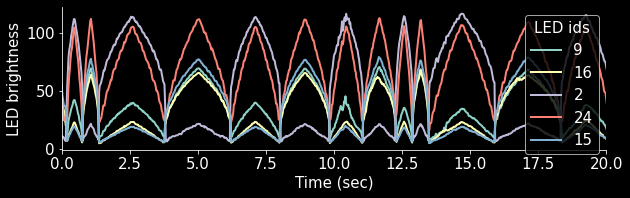

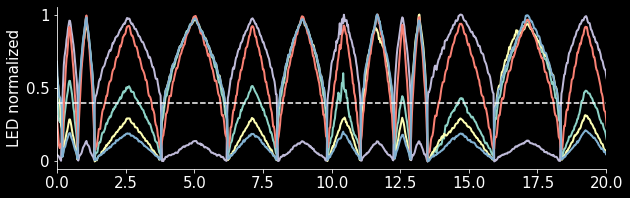

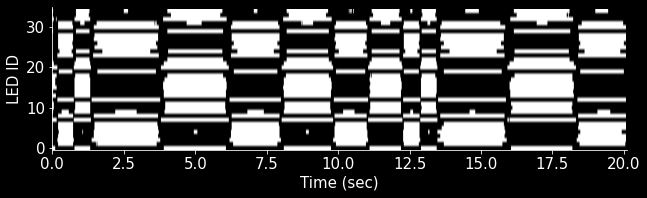

In [50]:
numbers = np.arange(35)  # This creates an array with numbers from 0 to 35
n_signals = 5
sample = np.random.choice(numbers, size=n_signals, replace=False)
tvec  = [x  / 40 for x in xframes]

# PLOT 1
plt.figure(figsize=(9,3))
plt.plot(tvec, mat[:, sample], lw=2, label=sample);
plt.xlabel("Time (sec)")
plt.ylabel("LED brightness")
plt.xlim([0, 20])
plt.legend(title="LED ids", loc="upper right")
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-sample-raw-brightness_.jpg", dpi=300)


# PLOT 2
norm_mat = (mat - mat.min(axis=0)) / (mat - mat.min(axis=0)).max(axis=0)
plt.figure(figsize=(9,3))
plt.plot(tvec, norm_mat[:, sample], lw=2, label=sample);
plt.plot([0,20],[.4, .4],"--w")
plt.yticks(ticks=[0, .5, 1], labels=[0, .5, 1])
plt.ylabel("LED normalized")
plt.xlim([0, 20])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-sample-normalized-brightness_.jpg", dpi=300)

# PLOT 3
led_thres = 0.4
bin_mat = norm_mat > led_thres
plt.figure(figsize=(9.25,3))
plt.imshow(np.transpose(bin_mat), aspect="auto",cmap="gray")
plt.ylim([-.5, 35])
plt.ylabel("LED ID")
plt.xticks(ticks=xframes[::100], labels=tvec[::100]);
plt.xlabel("Time (sec)")
plt.xlim([0, len(tvec)])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-thresholded-ON-OFF_.jpg", dpi=300)

# make slides in gooogle drive with presentation then copy into readme-images/ folder for illustration in readme


# Introduce Threshold red-line for .5 of normalized instensity
- also possible to set threshold at around .4 and start with a linear blue7red scale from there till 1.

- Plot bboxes of LEDs first then integrate light

# Plot the cutouts on a black background but at their location!
- this will make it clear I hope!

NameError: name 'bbox_' is not defined

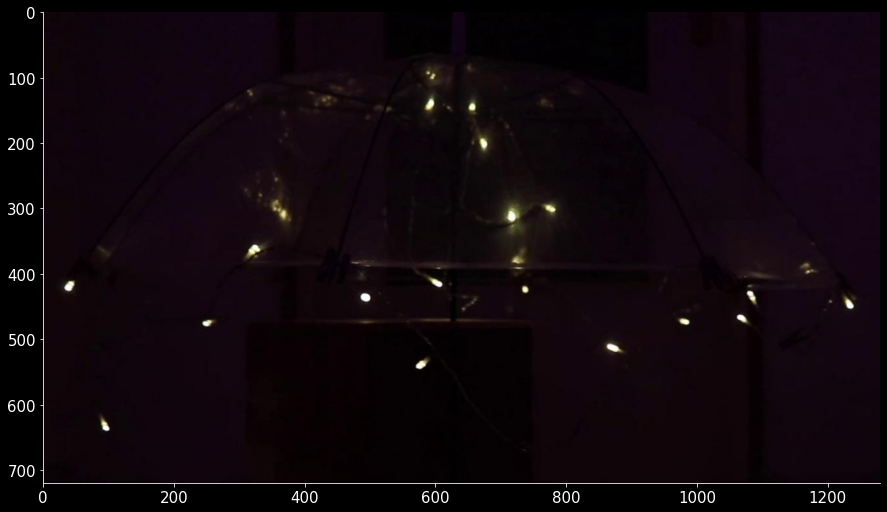

In [51]:
# PLOT IDENTIFIED ROI WITH NUMBERS, THEN USE NUMBERS TO LABEL TRACES / OR COLOR


# GET PLOT BBOX FUNCTION TO PLOT

plt.figure(figsize=(15,15))
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))

for bbox in bbox_:
    plt.plot(
        [bbox[2], bbox[2], bbox[3], bbox[3], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-or",)



In [ ]:
mat.max()

In [ ]:
mat = pd.DataFrame(mat, columns=[f"center_{n}" for n in range(len(centers))])
mat = mat / mat.mean().mean()
mat = mat / mat.max()
#mat.max().max()
# rollingmean()

In [ ]:
# take xframe 483, sorty by activity and use the sorting for visualisation
srt_idx = np.where([x == 483 for x in xframes])[0]
sorted_indices = np.argsort(mat.iloc[srt_idx, :].values)[0]
#mat.iloc[sorted_indices,:]
#sorted_indices

# Introduce Threshold red-line for .5 of normalized instensity
- also possible to set threshold at around .4 and start with a linear blue7red scale from there till 1.

In [ ]:
corrcoeff

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(xframes, np.ones(len(xframes)), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([400, 600])

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([450, 525])

plt.figure(figsize=(22,6.6))
plt.imshow(mat.iloc[:, sorted_indices].T, cmap="bwr")
#plt.axis("square")
plt.colorbar()
plt.xlim([450, 525])
plt.ylim([0, 35])

In [ ]:
# cut out clusters and show the averGES!

In [ ]:
plt.figure(figsize=(6,8))
counter = 0
for ith in sorted_indices:
    plt.plot(xframes, counter + mat.iloc[:, ith], "-w", lw=2)
    counter += 1
    
plt.xlim([200, 600])